## Financial clustering  📊

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.metrics import pairwise_distances


%matplotlib inline

from ydata_profiling import ProfileReport
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, completeness_score
from scipy.spatial import distance

### Data visualization 🔍

In [14]:
data_train = pd.read_csv("data/data_train.csv")
data_test = pd.read_csv("data/data_test.csv")

train_df_profile = ProfileReport(data_train, title = "Raw train data profile")
train_df_profile.to_file(os.path.join("visualization","train_df_profile.html"))

# Filter the data train by the cluster column
num_clusters = len(data_train['cluster'].unique())

for num_cluster in range(num_clusters):
    cluster = data_train[data_train['cluster'] == num_cluster]
    cluster_profile = ProfileReport(cluster, title = "Cluster " + str(num_cluster) + " profile")
    cluster_profile.to_file(os.path.join("visualization","cluster_" + str(num_cluster) + "_profile.html"))


Summarize dataset:  33%|███▎      | 6/18 [00:00<00:00, 93.33it/s, Describe variable:cluster]  

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 19.39it/s]
/home/mvanzulli/Desktop/challenge_1/.venv/lib/python3.11/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 152.50it/s]
/home/mvanzulli/Desktop/challenge_1/.venv/lib/python3.11/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 136.08it/s]
/home/mvanzulli/Desktop/challenge_1/.venv/lib/python3.11/site-packages/ydata_profiling/utils/dataframe.

Mean and variance evolution in months for each cluster

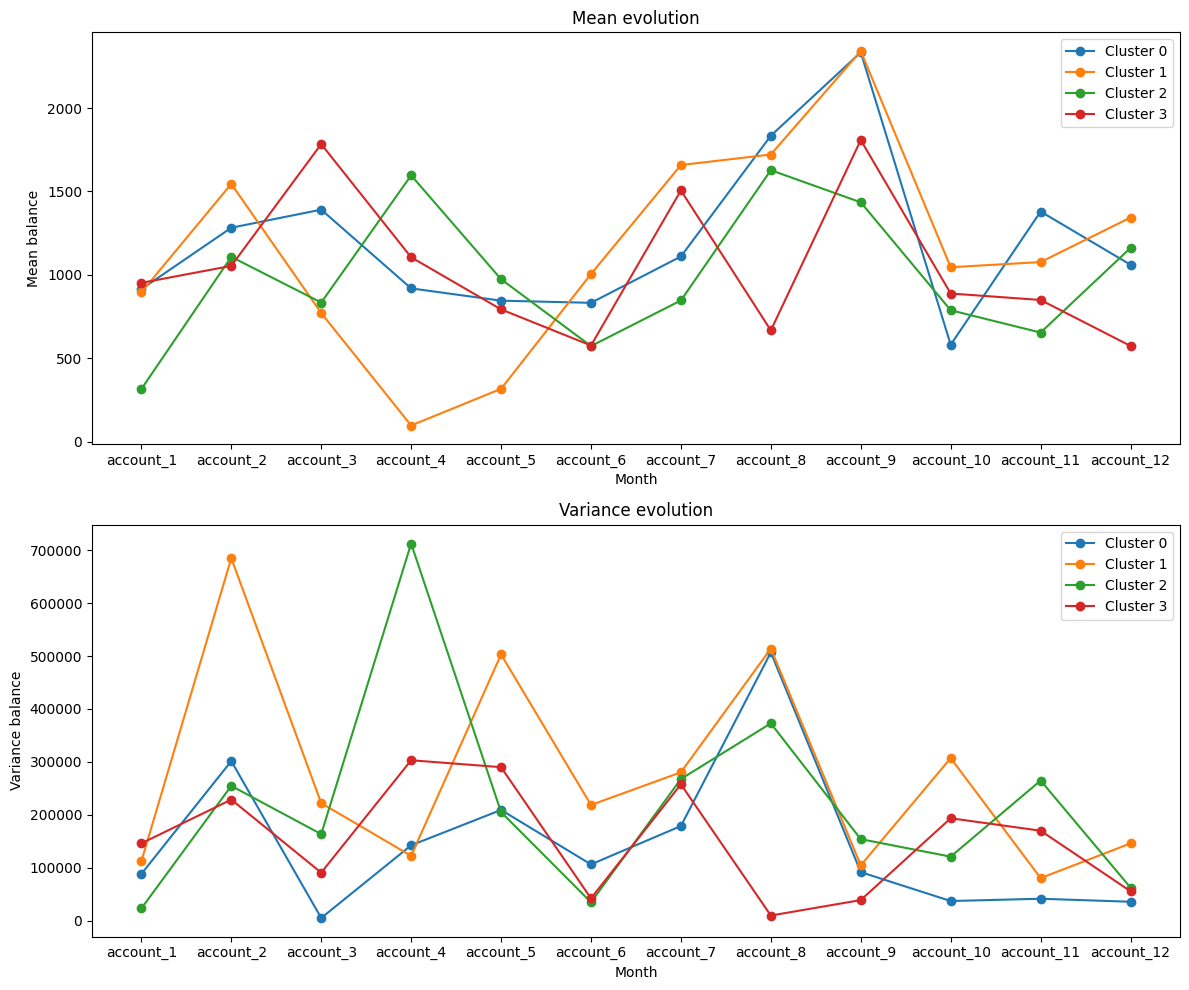

In [15]:
means = data_train.groupby('cluster').mean()
variances = data_train.groupby('cluster').var()

# Create figure and axes
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot the mean evolution for each cluster.
for cluster in range(num_clusters):
    ax[0].plot(means.columns, means.loc[cluster], 'o-', label=f'Cluster {cluster}')
ax[0].set_title('Mean evolution')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Mean balance')
ax[0].legend()

# Plot the variance evolution for each cluster.
for cluster in range(num_clusters):
    ax[1].plot(variances.columns, variances.loc[cluster], 'o-', label=f'Cluster {cluster}')
ax[1].set_title('Variance evolution')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Variance balance')
ax[1].legend()

plt.tight_layout()
plt.savefig(os.path.join("visualization","mean_variance_evolution.png"))


Outliers and box plots

/tmp/ipykernel_7806/1897089878.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_7806/1897089878.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_7806/1897089878.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_7806/1897089878.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



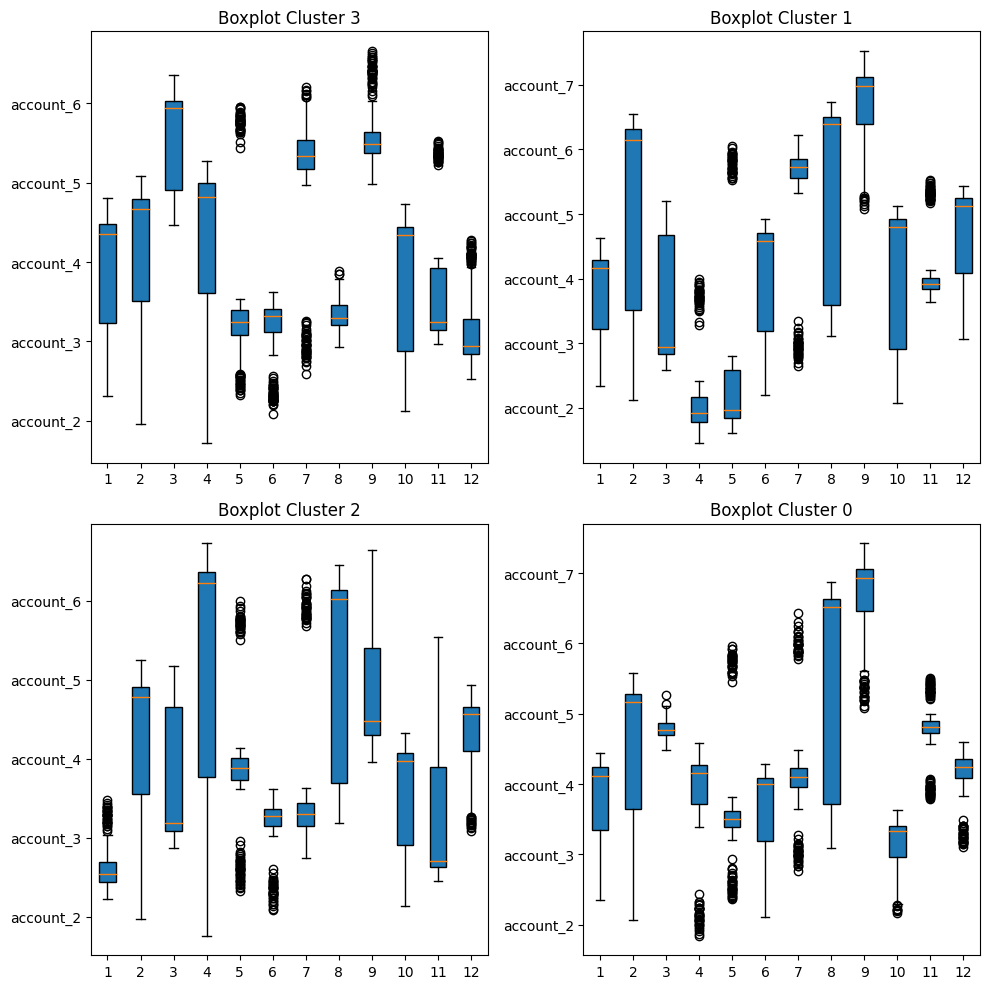

<Figure size 640x480 with 0 Axes>

In [16]:
# Box plot
fig, axes = plt.subplots(num_clusters//2, num_clusters//2, figsize=(10, 10))

clusters = data_train['cluster'].unique()

for i, cluster in enumerate(clusters):
    # Filter data for each cluster
    cluster_data = data_train[data_train['cluster'] == cluster].drop(columns='cluster')
    
    # Create a boxplot for each cluster
    row = i // 2
    col = i % 2
    axes[row, col].boxplot(cluster_data.values, vert=True, patch_artist=True)
    axes[row, col].set_title(f'Boxplot Cluster {cluster}')
    axes[row, col].set_yticklabels(cluster_data.columns)

plt.tight_layout()
plt.show()
plt.savefig(os.path.join("visualization","boxplot_clusters.png"))


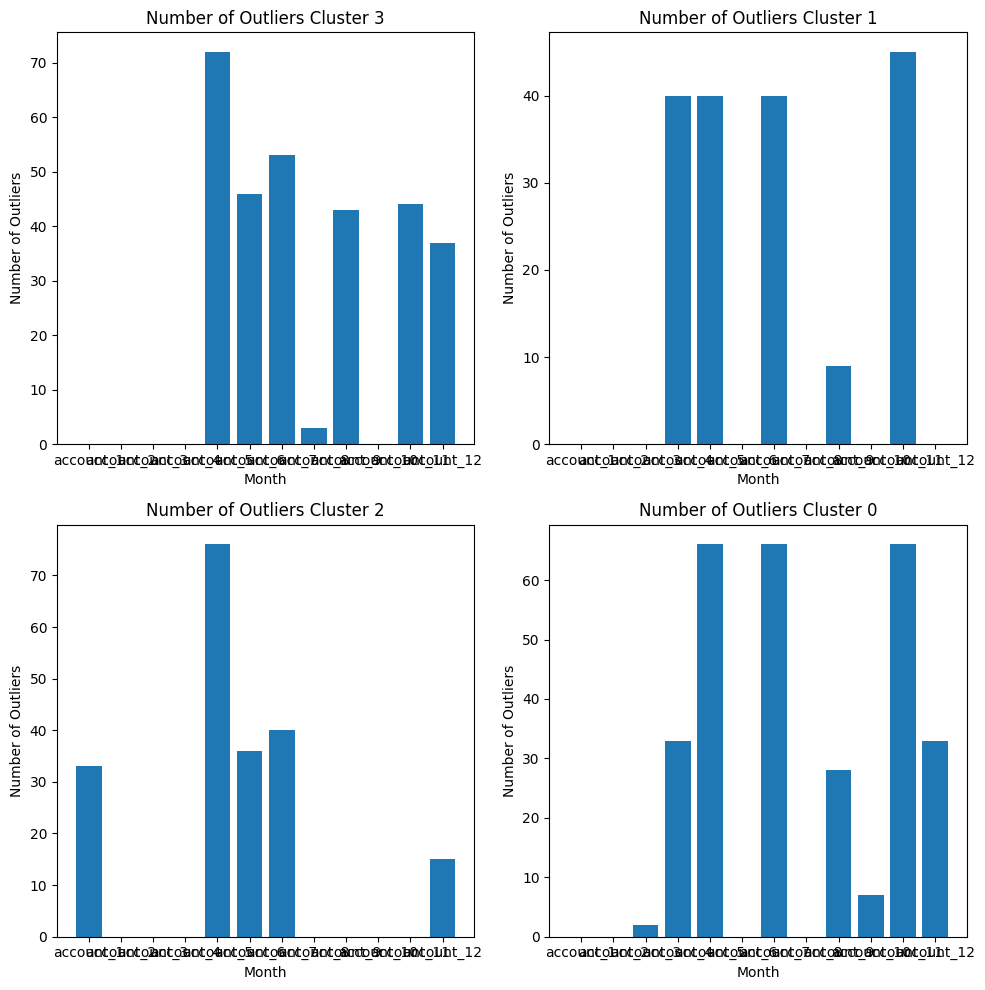

In [17]:
# Outliers
fig, axes = plt.subplots(num_clusters//2, num_clusters//2, figsize=(10, 10))
for i, cluster in enumerate(clusters):
    # Filter data for each cluster
    cluster_data = data_train[data_train['cluster'] == cluster].drop(columns='cluster')
    
    # Calculate the number of outliers for each month
    Q1 = cluster_data.quantile(0.25)
    Q3 = cluster_data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = cluster_data[(cluster_data < (Q1 - 1.5 * IQR)) | (cluster_data > (Q3 + 1.5 * IQR))].count()
    
    # Create a bar plot for each cluster
    row = i // 2
    col = i % 2
    axes[row, col].bar(cluster_data.columns, outliers)
    axes[row, col].set_title(f'Number of Outliers Cluster {cluster}')
    axes[row, col].set_xlabel('Month')
    axes[row, col].set_ylabel('Number of Outliers')

plt.tight_layout()
plt.savefig(os.path.join("visualization","outliers_clusters.png"))
plt.show()

PCA analysis

In [29]:
def standardize(df, train_df, drop_outliers=False):
    if drop_outliers:
        # Calculate IQR for each column
        Q1 = train_df.quantile(0.25)
        Q3 = train_df.quantile(0.75)
        IQR = Q3 - Q1

        # Define a mask for values that are NOT outliers
        mask = (train_df >= (Q1 - 1.5 * IQR)) & (train_df <= (Q3 + 1.5 * IQR))

        # Apply the mask to the DataFrame, this will replace outliers with NaN
        train_df = train_df[mask]

        # Drop rows containing NaN (i.e., rows that contained at least one outlier)
        train_df = train_df.dropna()

    for col in df.columns:
        if col != "cluster":
            mean = train_df[col].mean()
            std = train_df[col].std()
            df[col] = df[col].apply(lambda x: round((x - mean) / std, 3))
    return df


sd_train = standardize(data_train.copy(), data_train, drop_outliers=True)


# Perform PCA
pca = PCA(n_components=3)  
principalComponents = pca.fit_transform(sd_train)

# Convert to DataFrame for convenience
principalDf = pd.DataFrame(data=principalComponents, columns=['PC 1', 'PC 2', 'PC 3'])

# Add back the cluster column
finalDf = pd.concat([principalDf, data_train[['cluster']].reset_index(drop=True)], axis=1)

# Create the 3D plot
fig = px.scatter_3d(finalDf, x='PC 1', y='PC 2', z='PC 3',
                    color='cluster', 
                    labels={'color':'Cluster'},
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
# Save html file 
fig.write_html(os.path.join("visualization","pca_clusters.html"))

In [27]:

from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=3)  # We select 3 as we want to plot in 3D
tsne_results = tsne.fit_transform(sd_train)

# Convert to DataFrame for convenience
tsneDf = pd.DataFrame(data=tsne_results, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

# Add back the cluster column
finalDf = pd.concat([tsneDf, data_train[['cluster']].reset_index(drop=True)], axis=1)

# Create the 3D plot
fig = px.scatter_3d(finalDf, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    color='cluster', 
                    labels={'color':'Cluster'},
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
fig.write_html(os.path.join("visualization","tsne_clusters.html"))

First takes 
- The data is clean and we have no missing or strange values.
- There is a big difference in the corraltion heatap in the data among clusters 
- The data has a not null outliers that k-means can't handle. However the visualtization shows that there is not a huge impact on the clusters structure. 
- The clusters shape seem to be convex which is important to use k-means 
- PCA shows 6 clusts ( PCA is a lienar transformation that changes vairancesby projecting onto the direction that varies the most. It can't capture complex patterns in higher dimensions. )
- T-SNE shows more than 6 clusters ( PCA is a not lienar transformation that keeps similar instances close and dissimilar instances apart )

### Implementing k-means algorithm 🦾

In [70]:
def cluster_customers(data_train, data_test):
    max_iter = 58
    n_init = 18
    random_state = 8
    tol = 0.85
    threashlod = 20

    def standardize(df, train_df):
        for col in df.columns:
            if col != "cluster":
                mean = train_df[col].mean()
                std = train_df[col].std()
                df[col] = df[col].apply(lambda x: round((x - mean) / std, 3))
        return df

    sd_train = standardize(data_train.copy(), data_train).drop("cluster", axis=1)
    sd_test = standardize(data_test.copy(), data_train).drop("cluster", axis=1)

    wcss = []
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = KMeans(
            n_clusters=i,
            init="k-means++",
            max_iter=max_iter,
            n_init=n_init,
            random_state=random_state,
            tol=tol,
        )
        kmeans.fit(sd_train)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(sd_train, kmeans.labels_))

    opt_cluster = 2
    for i, j in enumerate(wcss[:-1]):
        if abs(wcss[i + 1] - j) < threashlod:
            opt_cluster = i + 2
            break

    # Kmeans optimal clusters
    print(f"Optimal cluster number is: {opt_cluster}")

    kmeans_opt = KMeans(
        n_clusters=opt_cluster,
        init="k-means++",
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
        tol=tol,
    ).fit(sd_train)

    silhouette_opt = silhouette_score(sd_train, kmeans_opt.labels_)
    completeness_opt = (
        completeness_score(data_train["cluster"], kmeans_opt.labels_),
        completeness_score(data_test["cluster"], kmeans_opt.predict(sd_test)),
    )

    labels_predicted_opt = kmeans_opt.predict(sd_test).tolist()
    
    #
    observation_of_interest = 0
    distances = [
        distance.euclidean(kmeans_opt.cluster_centers_[i], sd_test.iloc[observation_of_interest])
        for i in range(opt_cluster)
    ]
    max_opt = [x for _, x in sorted(zip(distances, range(opt_cluster)), reverse=True)]

    # Kmeans 4 clusters
    kmeans_4 = KMeans(
        n_clusters=4,
        init="k-means++",
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
        tol=tol,
    ).fit(sd_train)

    labels_predicted_4 = kmeans_4.predict(sd_test).tolist()
    silhouette_4 = silhouette_score(sd_train, kmeans_4.labels_)
    completeness_4 = (
        completeness_score(data_train["cluster"], kmeans_4.labels_),
        completeness_score(data_test["cluster"], kmeans_4.predict(sd_test)),
    )

    return {
        "sd_train": sd_train,
        "sd_test": sd_test,
        "wcss": wcss,
        "opt_cluster":opt_cluster,
        "silhouette_scores": silhouette_scores,
        "kmeans_opt": kmeans_opt,
        "silhouette_opt": silhouette_opt,
        "completeness_opt": completeness_opt,
        "labels_predicted_opt": labels_predicted_opt,
        "silhouette_4": silhouette_4,
        "completeness_4": completeness_4,
        "labels_predicted_4": labels_predicted_4,
        "distances": distances,
        "max_opt": max_opt,
    }

results =  cluster_customers(data_train, data_test)

Optimal cluster number is: 6


### Silhouette and elbow's method scores 🥸  

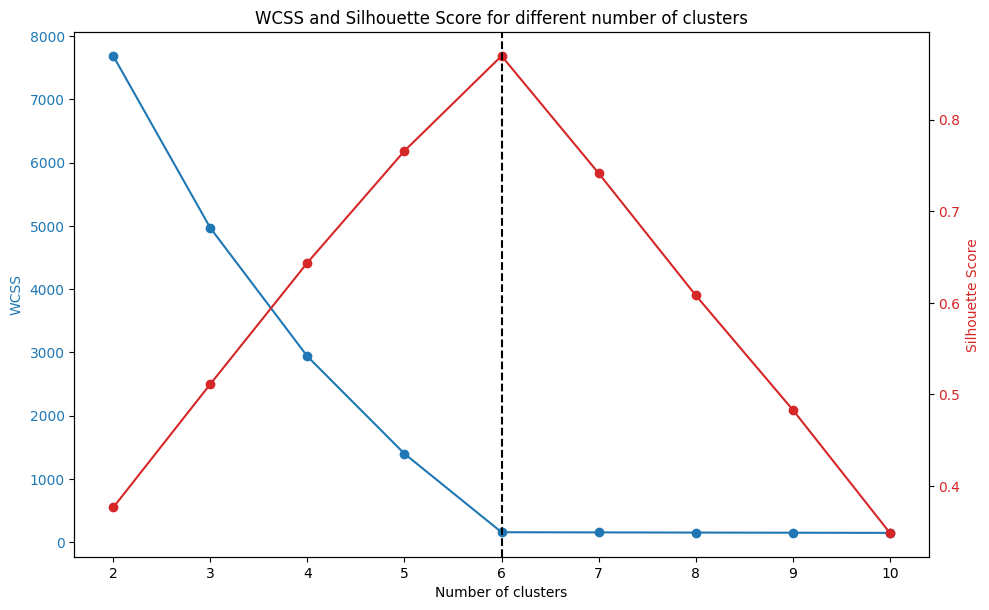

In [43]:
# Plot results 
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot WCSS (elbow method)
color = 'tab:blue'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(range(2, 11), results['wcss'], 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot silhouette scores
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(range(2, 11), results['silhouette_scores'], 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Plot the optimal number of clusters
plt.axvline(x=results["opt_cluster"], color='k', linestyle='--')


fig.tight_layout()
plt.title('WCSS and Silhouette Score for different number of clusters')
plt.show()


In [78]:

print("\nObservation 0 analysis:")
original_cluster = data_test.iloc[0]["cluster"]
print(f"The original cluster of is: {original_cluster}")

previous_cluser = results["sd_test"].iloc[0]
distances = results["distances"]
print(f"Distances to centroids are: {results['distances']}")
max_opt = results["max_opt"]
print(f"Order of clusters (first is the farthest): {max_opt}")

def single_sample_silhouette_score(X, labels, index):
    distances = pairwise_distances(X)
    a = np.mean([distances[index, i] for i in np.where(labels == labels[index])[0] if i != index])
    b = np.min([np.mean([distances[index, i] for i in np.where(labels == l)[0]]) for l in set(labels) if l != labels[index]])
    return (b - a) / max(a, b)

X_test = results["sd_test"].to_numpy()

labels_predicted_opt = np.array(results["labels_predicted_opt"])
shilhouette_score_opt = single_sample_silhouette_score(X_test, labels_predicted_opt, 0)
print(f"Optimal kmeans Silhouette for is: {shilhouette_score_opt}")

labels_predicted_4 = np.array(results["labels_predicted_4"])
shilhouette_score_4 = single_sample_silhouette_score(X_test, labels_predicted_4, 0)
print(f"4 kmeans Silhouette for is: {shilhouette_score_4}")



Observation 0 analysis:
The original cluster of is: 2
Distances to centroids are: [6.437298274392955, 0.508479879408207, 4.6413403948665275, 5.721188332401293, 5.124893628011185, 4.752451170596666]
Order of clusters (first is the farthest): [0, 3, 4, 5, 2, 1]
Optimal kmeans Silhouette for is: 0.8647535004485878
4 kmeans Silhouette for is: 0.8705801826475396


### Challenge analysis 𓀁

Overall samples are well clustered highest shioulette socre and the clusters are compact (enogh good WCSS value), which are desirable properties in a clustering solution.

1 ¿ Why is important to standarize the data ?
   - Removes bias or scaling issues that may affect the algorithm.
   - The mean and standard deviation of the training data are used to standardize both the training and testing data to ensure consistency and avoid data leakage. 
   - Data leakage could lead to an overoptimistic model performance. 

2 ¿ What WCSS has to do with Elbow Method ?
   - WCSS is the sum of square distances between each point and its centroid. 
   - WCSS measures compactness of the clusters.
   - The elbow method plots WCSS or model inertia and try to find a change in the derivative of the curve to pick the optimal number of clusters

3 ¿ What are the parameters that you selected ? 
   - The value `kmeans++` for the initialization parameter for a smart way than random to avoid poor clustering
   - Since the k-means method is sensitive to the initialization process `ninit` is the number times that the algorithm is run independently from different initialization and keep the best. 

4 ¿ What is completeness score ?

   - The completeness score is a measure of how much all members of a given class are assigned to the same cluster. If is 1 the we have clustered all the data points correct to the ground truths.

5 ¿ What is shouiette score ? 
   - The formula is for shouliette at point `i`. $$s(i) =  \frac{a(i) - b(i)}{ max(a(i), b(i))}$$ where
      - $a(i)$ is the mean distance between point i and inter cluster points.
      - $b(i)$ is the mean distance between point i and points that belong to the nearest cluster. 
      
   - Shouliete socres esentialy measures the distance between the clusters and the distance to nieghbouring clusters.Varies from [-1, to 1]. 
      - `1` means we have small intra  cluster distance and large inter cluster distance. 
      - `0` means that the clusters are overlapping.
      - `-1` means that the clusters are assigned in the wrong way.

5 ¿ Why is max opt computed ? 
   - Is just to predict the distances at specif observations of interest. This point presents a higher shiuliette method for the previous clustering however it is not the best cluster for the new data. Where in average the shouliette score is lower with 4 clusters. For clusterring all the points have the same weght 
